In [1]:
from tyxe_runfiles import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyro

In [2]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======


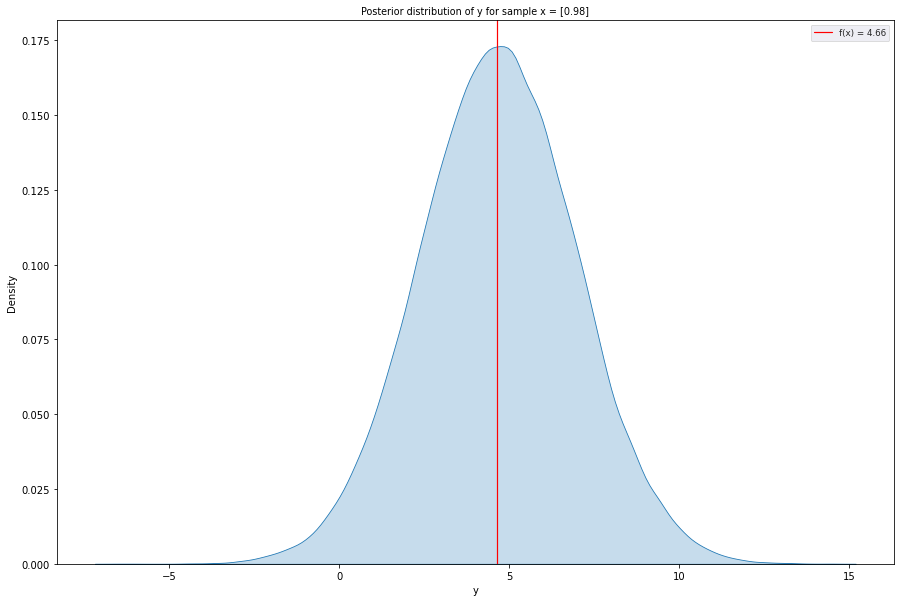

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])


In [6]:
x_train.shape, y_train.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [7]:
x_test[0], y_test[0]

(tensor([1.3441]), tensor([7.4088]))

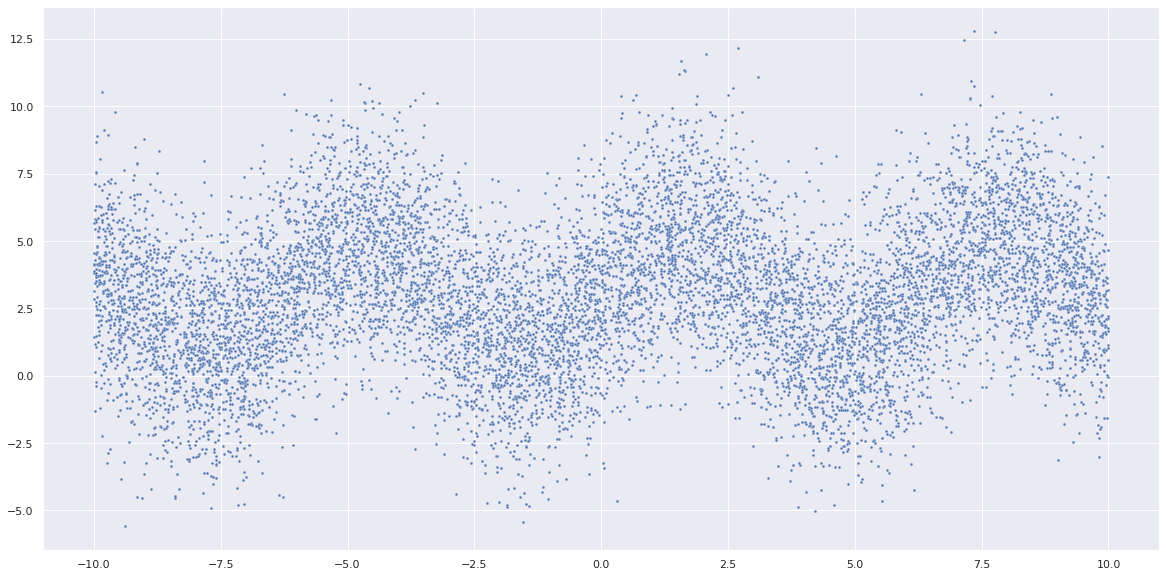

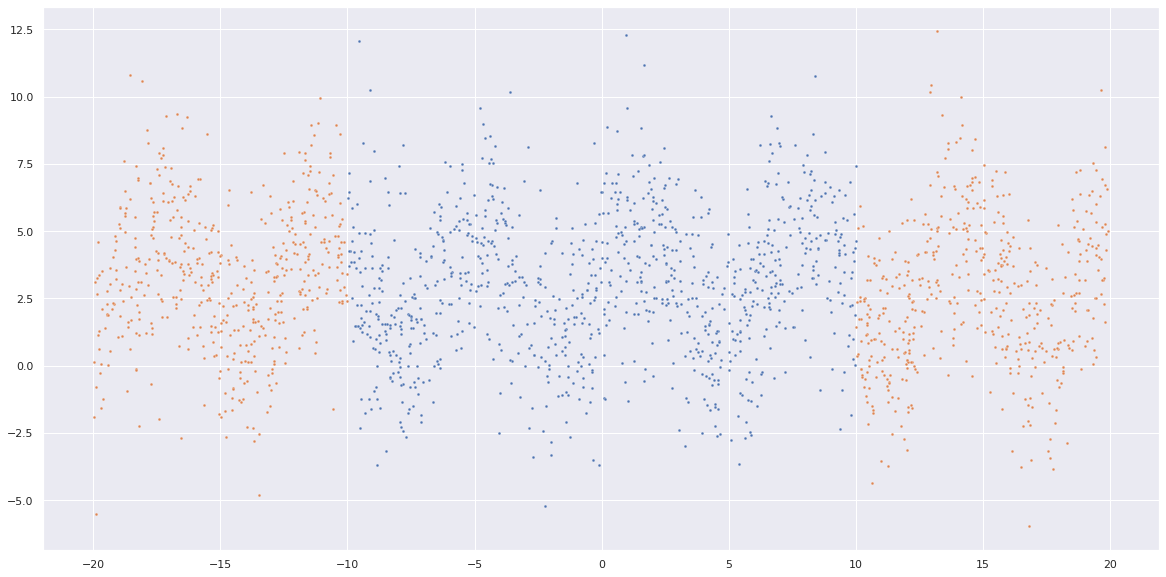

In [8]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train.flatten(), s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test_in_domain.flatten(), y=y_test_in_domain.flatten(), s=8, ax=ax)
sns.scatterplot(x=x_test_out_domain.flatten(), y=y_test_out_domain.flatten(), s=8, ax=ax)
plt.show()


In [9]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    bnn, train_stats = train.train(config, dataset_config, f"{BASE_DIR}")

(1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([512, 1]) torch.Size([512, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test =====
[0:00:00.295046] epoch: 0 | elbo: 8708.271069335937
[0:00:32.665756] epoch: 100 | elbo: 3731.05810546875
Training finished in 0:01:03.562403 seconds


In [ ]:
plt.plot(train_stats["elbo"])